In [124]:
!apt-get update -qq
!apt-get install -y -qq r-base r-base-dev
!pip install -q rpy2 pyrssa
!R -e "install.packages('Rssa', repos='https://cloud.r-project.org')"
!apt-get install -y -qq xvfb xauth x11-utils
!apt-get install -y -qq python3-tk
!pip install -q pyvirtualdisplay

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

R version 4.5.2 (2025-10-31) -- "[Not] Part in a Rumble"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages('Rssa', repos='https://cloud.r-project.org')
Installing package into ‘/usr/local/lib/R/site-library’
(a

In [125]:
import os
os.environ["R_HOME"] = "/usr/lib/R"
os.environ["MPLBACKEND"] = "Agg"
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
os.environ["DISPLAY"] = ""

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()

In [126]:
import time
import numpy as np
import pandas as pd
from typing import Literal
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import pyrssa as prs

# Примитивный пример с синусом

## Случай без шума

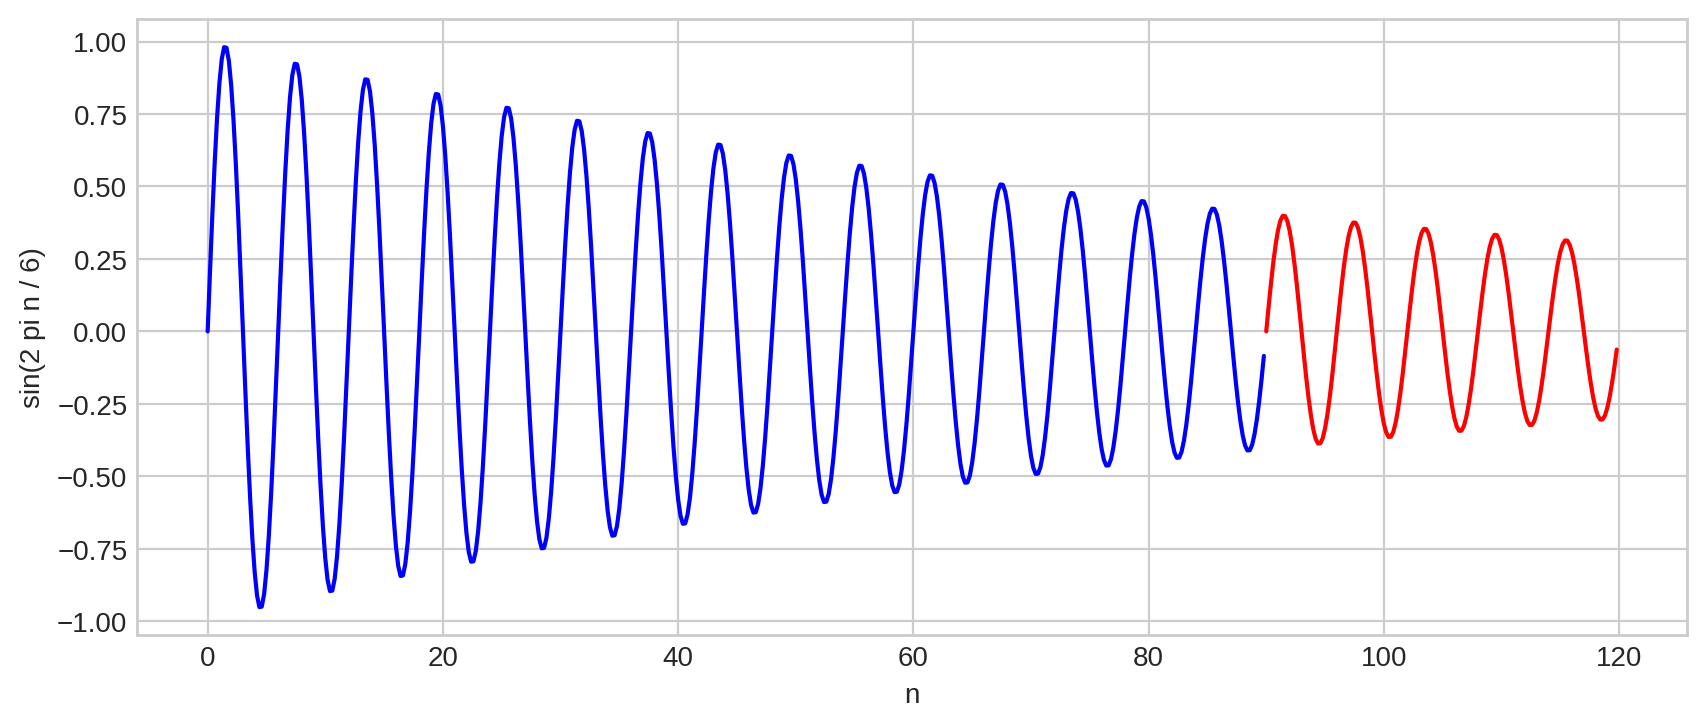

In [127]:
%matplotlib inline

N = 600
X_sin = np.array(range(0, N)) / 5
y_sin = np.exp(-1e-2 * X_sin) * np.sin(X_sin * 2 * np.pi / 6)

def split_ts(X, y, split_rate):
    N = len(X)
    assert N == len(y)
    last_train = int((1 - split_rate) * N)
    X_train, X_test = X[:last_train], X[last_train:]
    y_train, y_test = y[:last_train], y[last_train:]
    return X_train, X_test, y_train, y_test

tr = 0.25
X_sin_train_val, X_sin_test, y_sin_train_val, y_sin_test = split_ts(X_sin, y_sin, tr)

fig = plt.figure(figsize=(10, 4), dpi=200)
plt.xlabel("n")
plt.ylabel("sin(2 pi n / 6)")
plt.plot(X_sin_train_val, y_sin_train_val, color="blue")
plt.plot(X_sin_test, y_sin_test, color="red")
plt.show()

### RNN

На ряде без шума SSA проверять не имеет смысла (при $r=2$ ошибка будет нулевой)

### Создаём датасет и dataloaders

In [128]:
seq_len = 10
batch_size = 8

class SinDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data[idx:idx+self.seq_len]
        y_next = self.data[idx+self.seq_len]
        return x_seq.unsqueeze(-1), y_next.unsqueeze(-1)

X_sin_train, X_sin_val, y_sin_train, y_sin_val = split_ts(X_sin_train_val, y_sin_train_val, 0.25)

train_dataset = SinDataset(y_sin_train, seq_len)
val_dataset = SinDataset(y_sin_val, seq_len)
test_dataset = SinDataset(y_sin_test, seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Модель и цикл обучения

In [129]:
lr = 3e-4

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

print(f"{sum(p.numel() for p in model.parameters())} parameters")

3265 parameters


In [130]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)


def val_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(dataloader.dataset)


epochs = 100
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

0.493s, Epoch 5/100, Train Loss: 0.004472, Val Loss: 0.001023
1.157s, Epoch 10/100, Train Loss: 0.000667, Val Loss: 0.000371
1.787s, Epoch 15/100, Train Loss: 0.000481, Val Loss: 0.000266
2.752s, Epoch 20/100, Train Loss: 0.000405, Val Loss: 0.000230
3.480s, Epoch 25/100, Train Loss: 0.000320, Val Loss: 0.000275
4.395s, Epoch 30/100, Train Loss: 0.000278, Val Loss: 0.000106
5.186s, Epoch 35/100, Train Loss: 0.000262, Val Loss: 0.000132
6.192s, Epoch 40/100, Train Loss: 0.000217, Val Loss: 0.000183
7.333s, Epoch 45/100, Train Loss: 0.000190, Val Loss: 0.000167
8.412s, Epoch 50/100, Train Loss: 0.000170, Val Loss: 0.000144
9.698s, Epoch 55/100, Train Loss: 0.000130, Val Loss: 0.000087
10.729s, Epoch 60/100, Train Loss: 0.000117, Val Loss: 0.000051
11.929s, Epoch 65/100, Train Loss: 0.000105, Val Loss: 0.000068
12.954s, Epoch 70/100, Train Loss: 0.000092, Val Loss: 0.000068
14.267s, Epoch 75/100, Train Loss: 0.000075, Val Loss: 0.000111
17.567s, Epoch 80/100, Train Loss: 0.000081, Val Los

### Проверка

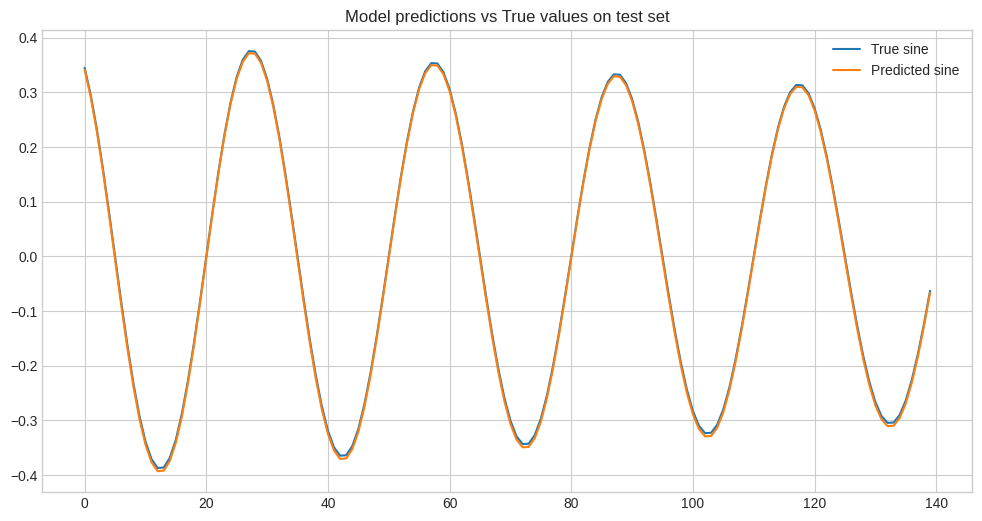

In [131]:
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        predictions.extend(output.cpu().numpy().flatten())
        ground_truth.extend(y.cpu().numpy().flatten())

plt.figure(figsize=(12,6))
plt.plot(ground_truth, label='True sine')
plt.plot(predictions, label='Predicted sine')
plt.legend()
plt.title('Model predictions vs True values on test set')
plt.show()

## Случай с шумом

In [132]:
def gen_noised_ts(y, noise_func=np.random.Generator.normal, **kwargs):
    N = len(y)
    noise = noise_func(size=N, **kwargs)

    return y + noise


def rmse(true, pred) -> float:
    return np.sqrt(np.mean((true - pred) ** 2))


sd = 0.6
repeats = 100
seed = 42

### SSA

In [133]:
def pred_ssa(y, L, rank, length, method: Literal["r", "v"]="r"):
    y_ssa = prs.ssa(y, L, kind="1d-ssa")
    match method:
        case "r":
            return prs.rforecast(y_ssa, groups={"Signal": range(1, rank + 1)}, length=length)
        case "v":
            return prs.vforecast(y_ssa, groups={"Signal": range(1, rank + 1)}, length=length)



def test_ssa(y_train, y_test, repeats, L, rank, seed=None, method: Literal["r", "v"]="r"):
    pred_len = len(y_test)
    rng = np.random.default_rng(seed)
    return np.mean(
        [
            rmse(
                y_test,
                pred_ssa(
                    gen_noised_ts(y_train, noise_func=rng.normal, scale=sd),
                    L,
                    rank,
                    pred_len,
                    method=method
                ),
            )
            for _ in range(repeats)
        ]
    )

ssa_rmse_r = test_ssa(
    y_train=y_sin_train, y_test=y_sin_test, repeats=repeats, L=N / 2, rank=2, seed=seed, method="r"
)

ssa_rmse_v = test_ssa(
    y_train=y_sin_train, y_test=y_sin_test, repeats=repeats, L=N / 2, rank=2, seed=seed, method="v"
)

print(f"RMSE for SSA (recursive forecast): {ssa_rmse_r:.5f}")
print(f"RMSE for SSA (vector forecast): {ssa_rmse_v:.5f}")

RMSE for SSA (recursive forecast): 0.34712
RMSE for SSA (vector forecast): 0.31525


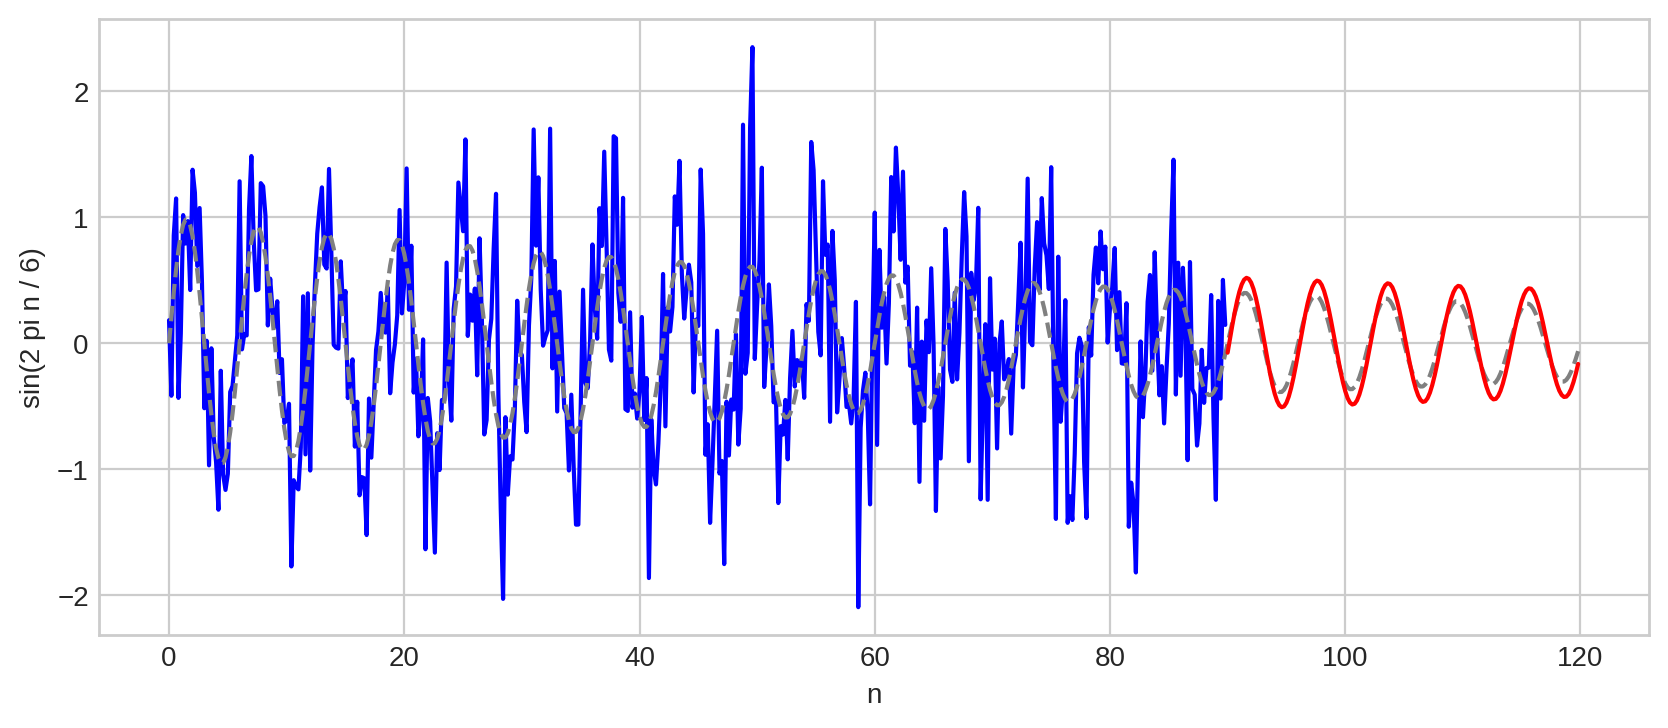

In [134]:
y_sin_train_noised = gen_noised_ts(
        y_sin_train_val, noise_func=np.random.default_rng(seed=seed).normal, scale=sd
    )
y_sin_pred = pred_ssa(
    y_sin_train_noised,
    N / 2,
    2,
    len(y_sin_test),
    "v"
)

fig = plt.figure(figsize=(10, 4), dpi=200)
plt.xlabel("n")
plt.ylabel("sin(2 pi n / 6)")
plt.plot(X_sin_train_val, y_sin_train_noised, color="blue")
plt.plot(X_sin, y_sin, color="gray", linestyle="--")
plt.plot(X_sin_test, y_sin_pred, color="red")
plt.show()

### RNN

### Аналогично, создаём датасет и dataloaders

In [135]:
y_sin_train_noised = gen_noised_ts(y_sin_train, noise_func=np.random.default_rng(seed=seed).normal, scale=sd)
y_sin_test_noised = gen_noised_ts(y_sin_test, noise_func=np.random.default_rng(seed=seed).normal, scale=sd)
y_sin_val_noised = gen_noised_ts(y_sin_val, noise_func=np.random.default_rng(seed=seed).normal, scale=sd)
y_sin_test_noised = gen_noised_ts(y_sin_test, noise_func=np.random.default_rng(seed=seed).normal, scale=sd)

train_dataset = SinDataset(y_sin_train_noised, seq_len)
val_dataset = SinDataset(y_sin_val_noised, seq_len)
test_dataset = SinDataset(y_sin_test_noised, seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Попробуем обучить GRU и LSTM

In [136]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

GRUModel = GRUModel().to(device)
LSTMModel = LSTMModel().to(device)

lr = 1e-4
criterion = nn.MSELoss()
GRUOptimizer = torch.optim.AdamW(GRUModel.parameters(), lr=lr)
LSTMOptimizer = torch.optim.AdamW(LSTMModel.parameters(), lr=lr)

print(f"{sum(p.numel() for p in GRUModel.parameters())} GRU parameters")
print(f"{sum(p.numel() for p in LSTMModel.parameters())} LSTM parameters")

9729 GRU parameters
12961 LSTM parameters


In [137]:
epochs = 100

print('=== GRU ===')
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(GRUModel, train_loader, criterion, GRUOptimizer, device)
    val_loss = val_epoch(GRUModel, val_loader, criterion, device)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print('=== LSTM ===')
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(LSTMModel, train_loader, criterion, LSTMOptimizer, device)
    val_loss = val_epoch(LSTMModel, val_loader, criterion, device)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

=== GRU ===
0.483s, Epoch 5/100, Train Loss: 0.570485, Val Loss: 0.287872
1.070s, Epoch 10/100, Train Loss: 0.507668, Val Loss: 0.268404
1.677s, Epoch 15/100, Train Loss: 0.462286, Val Loss: 0.257285
2.257s, Epoch 20/100, Train Loss: 0.436831, Val Loss: 0.252297
2.855s, Epoch 25/100, Train Loss: 0.422073, Val Loss: 0.250600
3.602s, Epoch 30/100, Train Loss: 0.413871, Val Loss: 0.251446
4.369s, Epoch 35/100, Train Loss: 0.411364, Val Loss: 0.252658
5.186s, Epoch 40/100, Train Loss: 0.408749, Val Loss: 0.254875
5.863s, Epoch 45/100, Train Loss: 0.406255, Val Loss: 0.254689
6.458s, Epoch 50/100, Train Loss: 0.404538, Val Loss: 0.255337
7.059s, Epoch 55/100, Train Loss: 0.402025, Val Loss: 0.257075
7.644s, Epoch 60/100, Train Loss: 0.401417, Val Loss: 0.257482
8.240s, Epoch 65/100, Train Loss: 0.398724, Val Loss: 0.258207
8.843s, Epoch 70/100, Train Loss: 0.398380, Val Loss: 0.258664
9.437s, Epoch 75/100, Train Loss: 0.394973, Val Loss: 0.259873
10.026s, Epoch 80/100, Train Loss: 0.393751,

GRU loss: 0.310251
LSTM loss: 0.323401


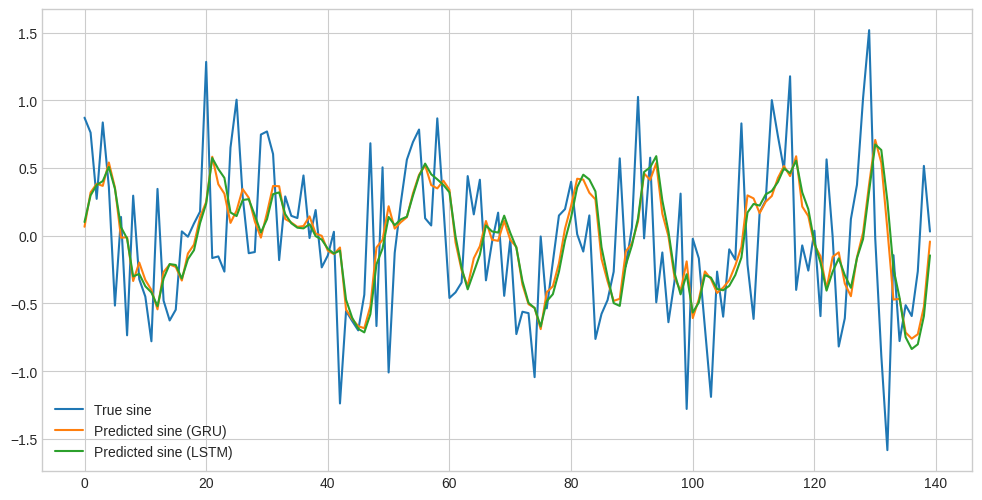

In [138]:
def estimateModels():
    GRUModel.eval()
    LSTMModel.eval()

    GRUPredictions = []
    LSTMPredictions = []
    truth = []

    with torch.no_grad():
        total_GRU_loss = 0.0
        total_LSTM_loss = 0.0

        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            GRUOutput = GRUModel(X)
            LSTMOutput = LSTMModel(X)

            GRUPredictions.extend(GRUOutput.cpu().numpy().flatten())
            LSTMPredictions.extend(LSTMOutput.cpu().numpy().flatten())
            truth.extend(y.cpu().numpy().flatten())

            GRULoss = criterion(GRUOutput, y)
            total_GRU_loss += GRULoss.item() * X.size(0)

            LSTMLoss = criterion(LSTMOutput, y)
            total_LSTM_loss += LSTMLoss.item() * X.size(0)

    print(f"GRU loss: {total_GRU_loss / len(test_loader.dataset):.6f}")
    print(f"LSTM loss: {total_LSTM_loss / len(test_loader.dataset):.6f}")

    plt.figure(figsize=(12,6))
    plt.plot(truth, label='True sine')
    plt.plot(GRUPredictions, label='Predicted sine (GRU)')
    plt.plot(LSTMPredictions, label='Predicted sine (LSTM)')
    plt.legend()
    plt.show()

estimateModels()

### Посмотрим, могут ли модели переобучиться

In [139]:
epochs = 1000

print('=== GRU ===')
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(GRUModel, train_loader, criterion, GRUOptimizer, device)
    val_loss = val_epoch(GRUModel, val_loader, criterion, device)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print('=== LSTM ===')
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(LSTMModel, train_loader, criterion, LSTMOptimizer, device)
    val_loss = val_epoch(LSTMModel, val_loader, criterion, device)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

=== GRU ===
6.353s, Epoch 50/1000, Train Loss: 0.376690, Val Loss: 0.275267
12.254s, Epoch 100/1000, Train Loss: 0.372543, Val Loss: 0.283308
18.762s, Epoch 150/1000, Train Loss: 0.368767, Val Loss: 0.286966
25.133s, Epoch 200/1000, Train Loss: 0.366042, Val Loss: 0.292350
31.644s, Epoch 250/1000, Train Loss: 0.360857, Val Loss: 0.296771
37.464s, Epoch 300/1000, Train Loss: 0.355272, Val Loss: 0.300673
44.483s, Epoch 350/1000, Train Loss: 0.349502, Val Loss: 0.309252
50.331s, Epoch 400/1000, Train Loss: 0.343634, Val Loss: 0.317342
56.874s, Epoch 450/1000, Train Loss: 0.338503, Val Loss: 0.326223
62.761s, Epoch 500/1000, Train Loss: 0.330438, Val Loss: 0.340949
69.262s, Epoch 550/1000, Train Loss: 0.325635, Val Loss: 0.345598
75.068s, Epoch 600/1000, Train Loss: 0.317916, Val Loss: 0.359931
81.536s, Epoch 650/1000, Train Loss: 0.310699, Val Loss: 0.370777
87.510s, Epoch 700/1000, Train Loss: 0.300873, Val Loss: 0.379932
94.094s, Epoch 750/1000, Train Loss: 0.292176, Val Loss: 0.389587


GRU loss: 0.510439
LSTM loss: 0.536879


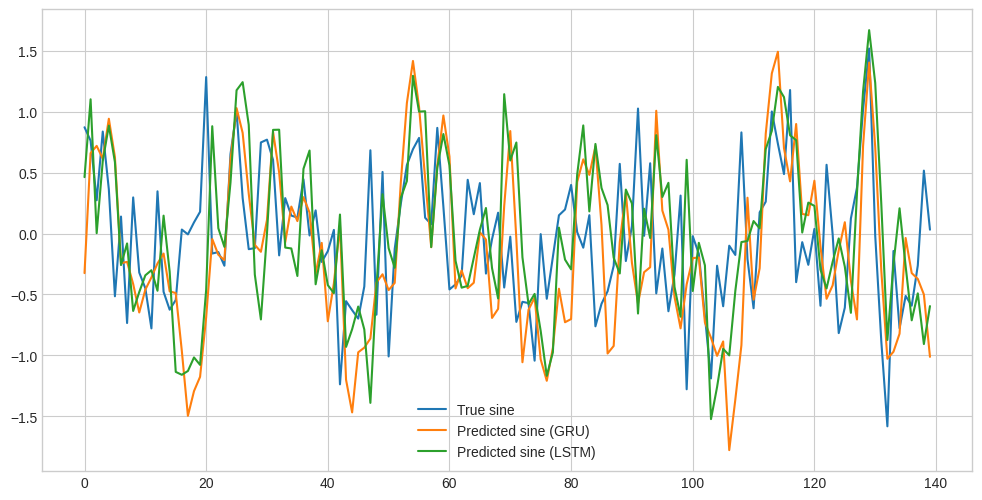

In [140]:
estimateModels()

# Реальный временной ряд

## Количество релизов музыкальных композиций по месяцам

In [141]:
df_music = pd.read_csv("/content/tracks_by_date.csv")
df_music.head()

,Unnamed: 0,Date,Count
0,1,1950-01,4
1,2,1950-02,16
2,3,1950-03,4
3,4,1950-04,17
4,5,1950-05,26


In [142]:
music_ts_index = pd.date_range(start=df_music["Date"][1], freq='ME', periods=len(df_music)).strftime('%Y-%m')
music_ts = pd.Series(df_music.Count.values, index=music_ts_index)
music_ts_recent = music_ts["2014-01":"2018-01"]
music_ts_actual = music_ts["2018-01":"2020-01"]
music_ts_actual_mspe = music_ts["2018-02":"2020-01"]

### Графики данных

- `music_ts`: за всё время
- `music_ts_recent`: за 2014-2018 гг. - для обучения
- `music_ts_actual`: за 2018-2020 - для тестирования

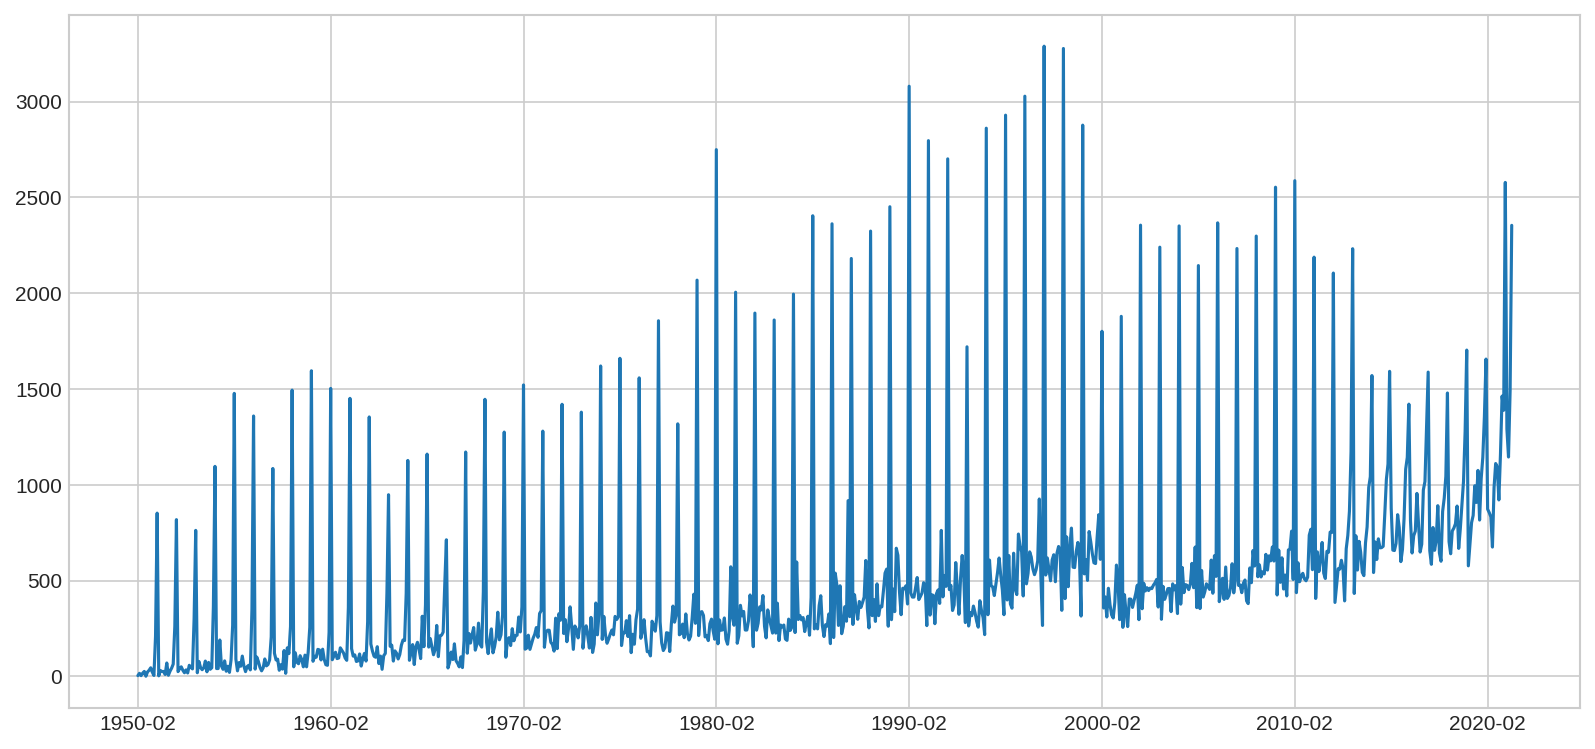

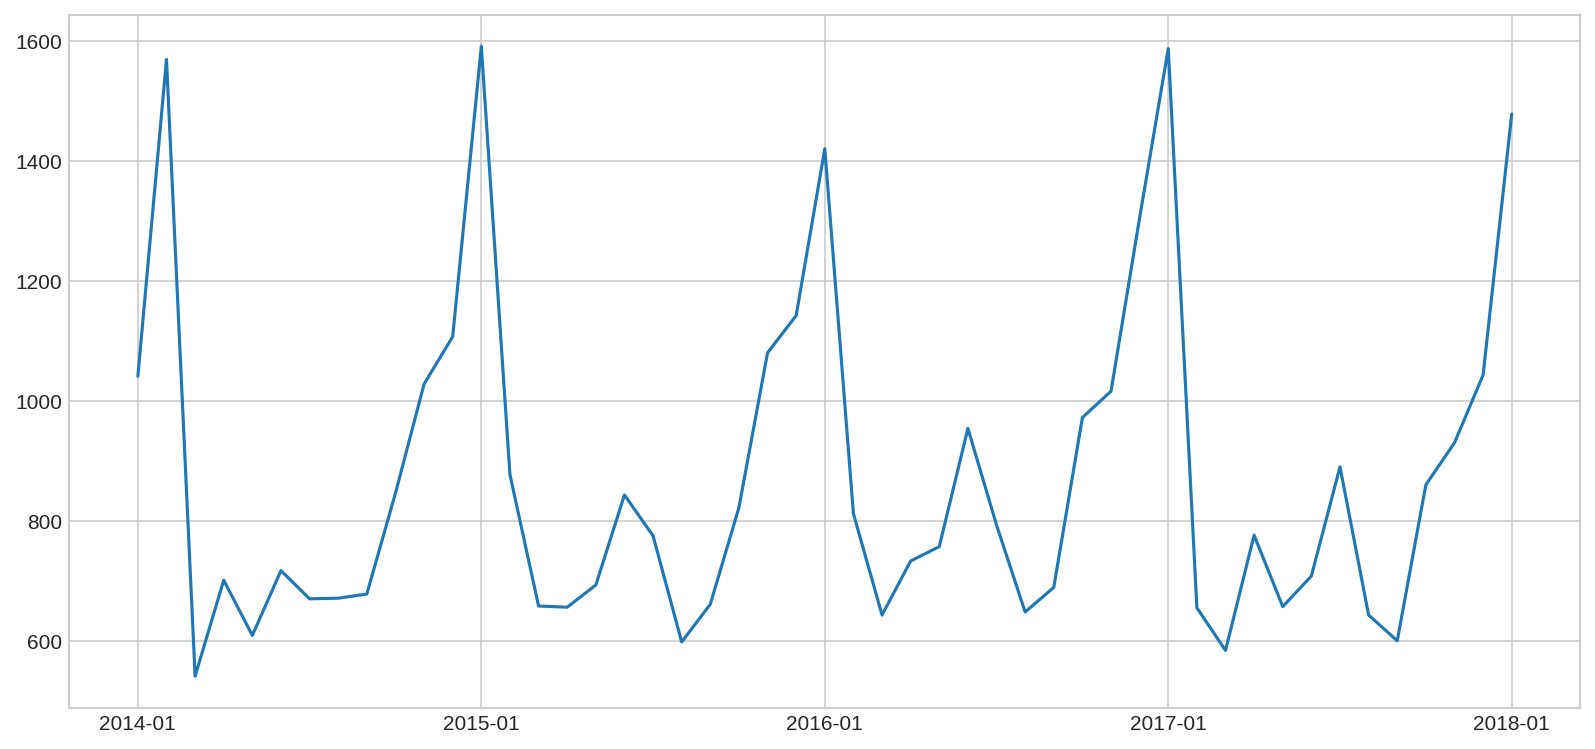

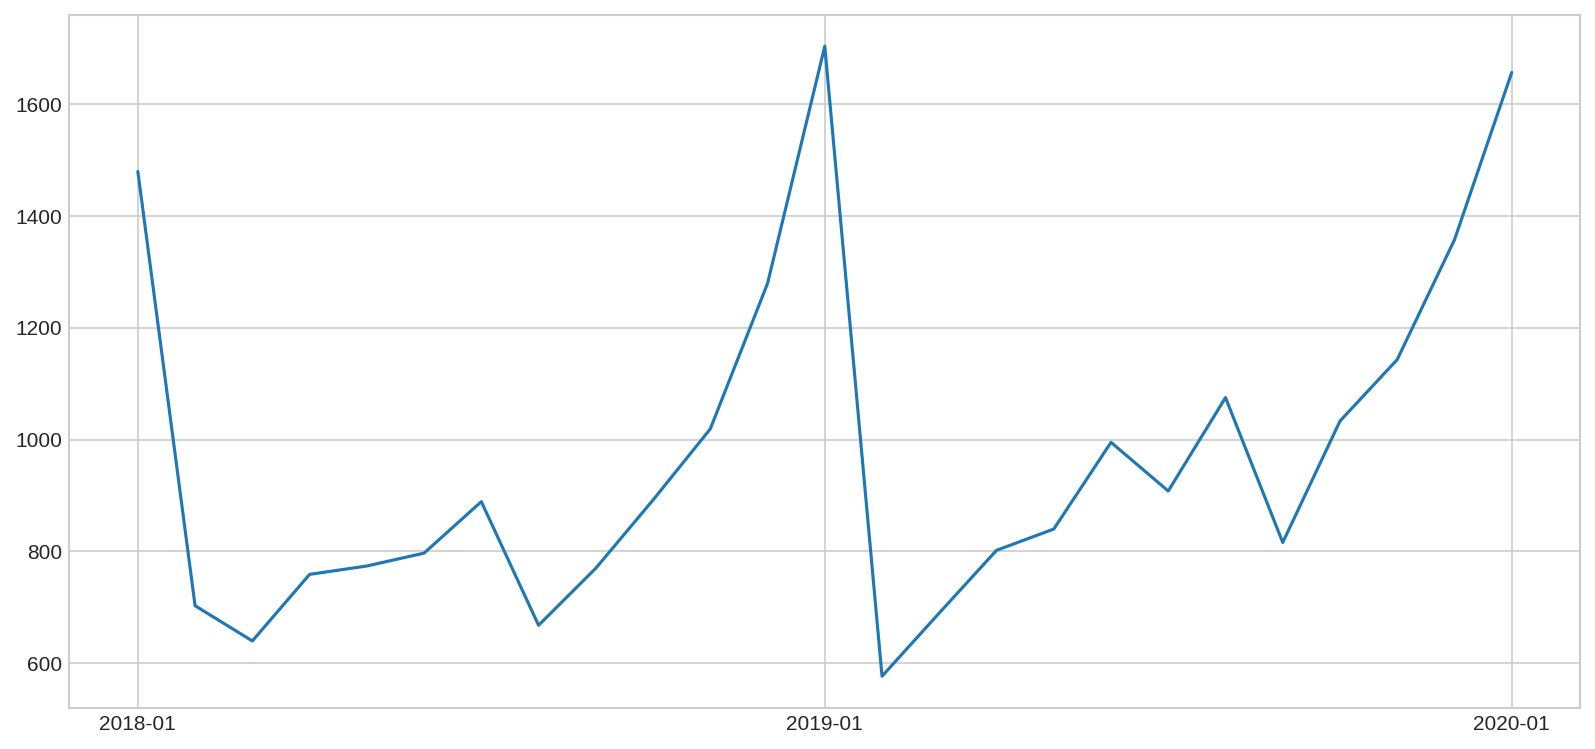

In [143]:
plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts)
plt.xticks(music_ts.index[::120])
plt.show()

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_recent)
plt.xticks(music_ts_recent.index[::12])
plt.show()

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_actual)
plt.xticks(music_ts_actual.index[::12])
plt.show()

## SSA

Базовое разложение

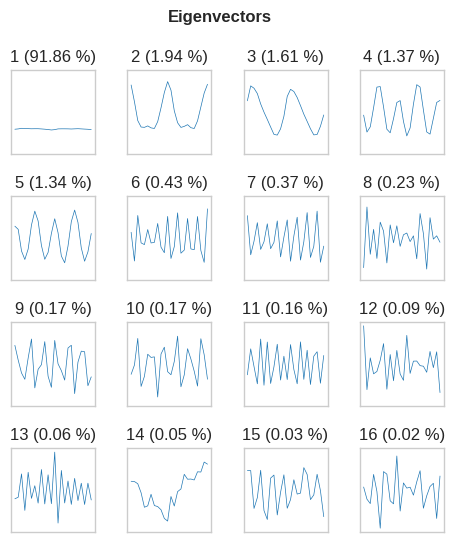

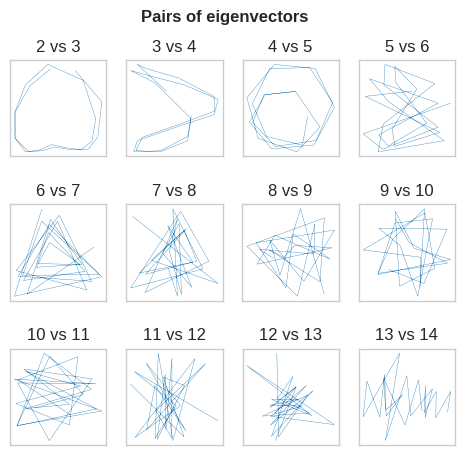

Trend:
   period     rate   |    Mod     Arg  |     Re        Im
      Inf   0.000805 |  1.00081   0.00 |  1.00081   0.00000

Seasonality:
   period     rate   |    Mod     Arg  |     Re        Im
    3.007   0.025242 |  1.02556   2.09 | -0.50815   0.89082
   -3.007   0.025242 |  1.02556  -2.09 | -0.50815  -0.89082
    5.954   0.000502 |  1.00050   1.06 |  0.49326   0.87046
   -5.954   0.000502 |  1.00050  -1.06 |  0.49326  -0.87046
    2.379  -0.002179 |  0.99782   2.64 | -0.87543   0.47883
   -2.379  -0.002179 |  0.99782  -2.64 | -0.87543  -0.47883
    3.928  -0.008625 |  0.99141   1.60 | -0.02858   0.99100
   -3.928  -0.008625 |  0.99141  -1.60 | -0.02858  -0.99100
   11.882  -0.015018 |  0.98509   0.53 |  0.85055   0.49697
  -11.882  -0.015018 |  0.98509  -0.53 |  0.85055  -0.49697
   -2.000  -0.560009 |  0.57120  -3.14 | -0.57120  -0.00000



In [144]:
music_ts_ssa = prs.ssa(music_ts_recent, L=len(music_ts_recent) // 12 // 2 * 12, kind="1d-ssa")
prs.plot(music_ts_ssa, kind="vectors", idx=np.arange(1, 17))
prs.plot(music_ts_ssa, kind="paired", idx=np.arange(2, 15), contrib=False)
print(prs.parestimate(music_ts_ssa, groups={"Trend": 1, "Seasonality": range(2, 13)}, method="esprit"))

### Восстановление по первым 12 компонентам

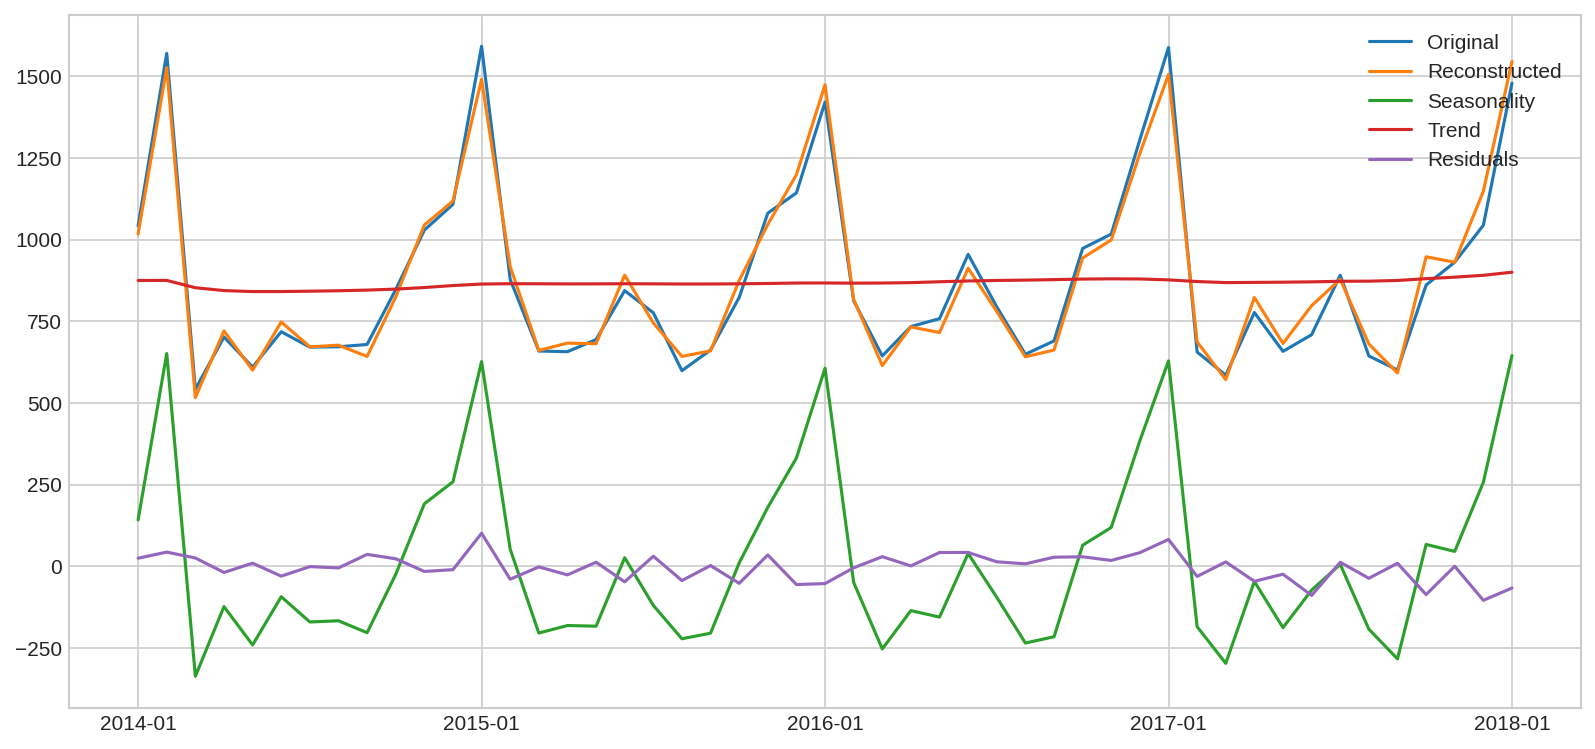

In [145]:
music_ts_rec = prs.reconstruct(music_ts_ssa, groups = {"Signal": range(1, 13), "Trend": 1, "Seasonality": range(2, 13)})

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_recent, label="Original")
plt.plot(music_ts_rec.Signal, label = "Reconstructed")
plt.plot(music_ts_rec.Seasonality, label = "Seasonality")
plt.plot(music_ts_rec.Trend, label = "Trend")
plt.plot(music_ts_rec.residuals, label = "Residuals")
plt.xticks(music_ts_recent.index[::12])
plt.legend()
plt.show()

### Предсказание (на 2 года)

Используется векторное предсказание (здесь рекуррентное будет менее точным)

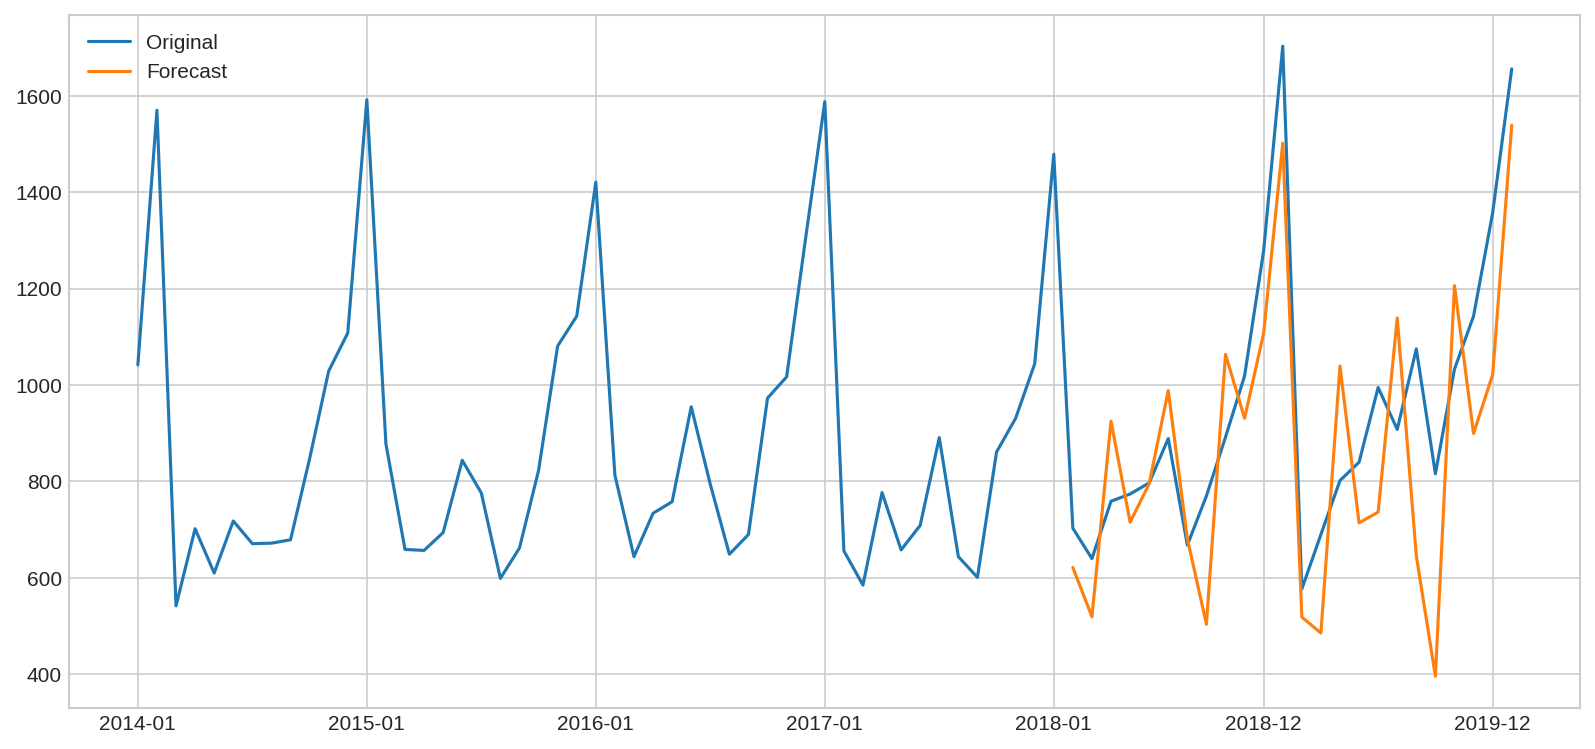

In [146]:
pred_len = 24
music_ts_vfor = prs.vforecast(music_ts_ssa, groups={"Signal": range(1, 13)}, length = pred_len)
music_ts_vfor.index = pd.date_range(start="2018-2", freq='ME', periods=pred_len).strftime('%Y-%m')

music_ts_original = pd.concat([music_ts_recent, music_ts_actual])

plt.figure(figsize=(13, 6), dpi=150)
plt.plot(music_ts_original, label="Original")
plt.plot(music_ts_vfor, label="Forecast")
plt.legend()
plt.xticks(music_ts_original.index[::12])
plt.show()

In [147]:
vfor_rmse = rmse(music_ts_actual_mspe, music_ts_vfor)
print(f"SSA forecast RMSE: {vfor_rmse}")

SSA forecast RMSE: 209.5595232437173


## RNN

### Датасет и dataloaders

In [148]:
df_music = pd.read_csv("/content/tracks_by_date.csv")

if 'Unnamed: 0' in df_music.columns:
    df_music = df_music.drop(columns=['Unnamed: 0'])

df_music['Date'] = pd.to_datetime(df_music['Date'], format='%Y-%m')
df_music.set_index('Date', inplace=True)
music_ts = df_music['Count']

seq_length = 24

test_len = 48
val_len = 48

end_date = music_ts.index.max()

test_start = end_date - pd.DateOffset(months=test_len) + pd.DateOffset(days=1)
val_start = test_start - pd.DateOffset(months=val_len)

train_series = music_ts[music_ts.index < val_start]
val_series = music_ts[(music_ts.index >= val_start) & (music_ts.index < test_start)]
test_series = music_ts[music_ts.index >= test_start]

class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_length):
        self.series = series.values.astype('float32')
        self.seq_length = seq_length

    def __len__(self):
        return len(self.series) - self.seq_length

    def __getitem__(self, idx):
        x = self.series[idx:idx + self.seq_length]
        y = self.series[idx + self.seq_length]
        return torch.tensor(x).unsqueeze(-1), torch.tensor(y).unsqueeze(-1)

scaler = MinMaxScaler()

train_values = train_series.values.reshape(-1, 1)
train_scaled = scaler.fit_transform(train_values)

val_scaled = scaler.transform(val_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

train_scaled_series = pd.Series(train_scaled.flatten(), index=train_series.index)
val_scaled_series = pd.Series(val_scaled.flatten(), index=val_series.index)
test_scaled_series = pd.Series(test_scaled.flatten(), index=test_series.index)

train_dataset = TimeSeriesDataset(train_scaled_series, seq_length)
val_dataset = TimeSeriesDataset(val_scaled_series, seq_length)
test_dataset = TimeSeriesDataset(test_scaled_series, seq_length)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


### Попробуем обучить GRU

In [149]:
class TSModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=63, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

lr = 1e-3

model = TSModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

print(f"{sum(p.numel() for p in model.parameters())} parameters")

36730 parameters


In [150]:
epochs = 100
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = val_epoch(model, val_loader, criterion, device)

    if (epoch + 1) % 5 == 0:
        print(f"{time.time() - start:.3f}s, Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

0.572s, Epoch 5/100, Train Loss: 0.023944, Val Loss: 0.009017
1.269s, Epoch 10/100, Train Loss: 0.008147, Val Loss: 0.004525
1.959s, Epoch 15/100, Train Loss: 0.004109, Val Loss: 0.005905
2.666s, Epoch 20/100, Train Loss: 0.003472, Val Loss: 0.007400
3.471s, Epoch 25/100, Train Loss: 0.003297, Val Loss: 0.008767
4.373s, Epoch 30/100, Train Loss: 0.003581, Val Loss: 0.009375
5.342s, Epoch 35/100, Train Loss: 0.003144, Val Loss: 0.007735
7.077s, Epoch 40/100, Train Loss: 0.002858, Val Loss: 0.006707
8.424s, Epoch 45/100, Train Loss: 0.003163, Val Loss: 0.008913
10.080s, Epoch 50/100, Train Loss: 0.003016, Val Loss: 0.006694
11.214s, Epoch 55/100, Train Loss: 0.003081, Val Loss: 0.005678
11.904s, Epoch 60/100, Train Loss: 0.003124, Val Loss: 0.004499
12.588s, Epoch 65/100, Train Loss: 0.003075, Val Loss: 0.007610
13.274s, Epoch 70/100, Train Loss: 0.002917, Val Loss: 0.006146
13.964s, Epoch 75/100, Train Loss: 0.002877, Val Loss: 0.006471
14.645s, Epoch 80/100, Train Loss: 0.002975, Val L

### Проверка модели

RMSE: 463.983619


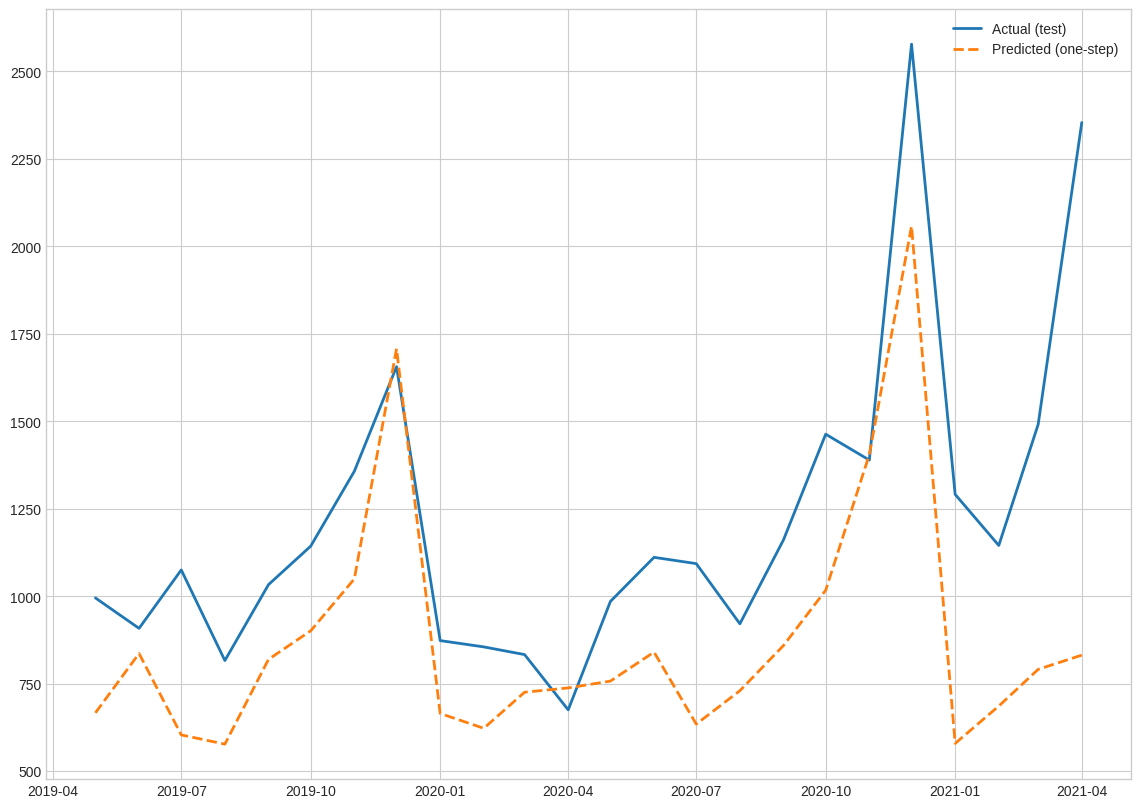

In [151]:
model.eval()
preds = []
targets = []

test_index_for_targets = test_scaled_series.index[seq_length:]

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        out = model(x_batch)  # [1, 1]
        preds.append(out.cpu().numpy().reshape(-1))
        targets.append(y_batch.cpu().numpy().reshape(-1))

preds_inv = scaler.inverse_transform(preds).flatten()
targets_inv = scaler.inverse_transform(targets).flatten()

pred_series = pd.Series(preds_inv, index=test_index_for_targets)
target_series = pd.Series(targets_inv, index=test_index_for_targets)

rmse = np.sqrt(mean_squared_error(targets_inv, preds_inv))
print(f"RMSE: {rmse:.6f}")

plt.figure(figsize=(14, 10))
plt.plot(target_series.index, target_series.values, label='Actual (test)', linewidth=2)
plt.plot(pred_series.index, pred_series.values, label='Predicted (one-step)', linestyle='--', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()